## Implementation of Weighted Jacobi and Gauss-Seidel

Import packages

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
import matplotlib.animation as ani
from matplotlib import rc
from IPython.display import HTML, Image
rc('animation', html='jshtml')
plt.style.use('seaborn')

Create a function which will accept a matrix and output vector to solve the matrix equation $Ax=b$ using Gauss-Seidel and Weighted Jacobi. This consists of splitting the matrix $A$ into the difference of two matrices, $A=M-N$. For Gauss-Seidel $M=D-L$, where $D$ is the diagonal component of $A$ and $L$ is the lower triangular component of $A$. For Weighted Jacobi $M=\frac{1}{\omega}D$, where $\omega$ is a parameter that is optimal when $\omega=\frac{2}{3}$. It is optimal in the sense that it minimizes the absolute value of eigenvalues in the oscillatory range of the matrix $I-\omega D^{-1}A$, thus minimizing the convergence rate.

If we focus on the range $\frac{n}{2}\leq k \leq n$, then since $\lambda_k(I-\omega D^{-1}A)=1-2\omega sin^2(\frac{k\pi}{2n})$, we can see that $1-2\omega sin^2(\frac{\pi}{4})\geq \lambda_k(I-\omega D^{-1}A) \geq 1-2\omega sin^2(\frac{\pi}{2})$. That is, $1-\omega\geq \lambda_k(I-\omega D^{-1}A) \geq 1-2\omega$. A hueristic way to minimize this set of $\lambda_k$ is find a value of $\omega$ such that the absolute value of the upper and lower bounds are equal\: $|1-\omega|=|1-2\omega|$. This has solutions $\omega=0, \frac{2}{3}$. Clearly $\omega=0$ is not a solution we want, so $\omega=\frac{2}{3}$ is a good hueristic optimal value. This is also explored below by looking at the error smooth out and decay over time.

The functions below take as input a given matrix A, an output vector $b$, and a given convergence tolerance $\epsilon$. The functions will implement the corresponding iterative solvers until the norm of the approximate solutions is less than the given tolerance, $||x_k||_{l_2}<\epsilon$. Our matrix $A$ is invertible so we know that $x_k$ should converge to the zero solution

In [ ]:
def GS(A, b, eps, x_true, x0):
  # first extract the diagonal entries of A and the triangular parts of A
  D = np.diag(np.diag(A))
  L = np.tril(A, k=-1)
  U = np.triu(A, k=1)

  # the goal of these iterative schemese is to have a matrix M that is easy to invert
  M = D+L
  N = U
  n = len(A)

  # store the resiudals and error at each iteration
  residuals = []
  errors = []
  iterates = []

  # now start the iteration
  xi = x0
  xi1 = np.linalg.solve(M, b) - np.linalg.solve(M, np.matmul(N,xi))
  iterates.append(abs(xi-x_true))
  iterates.append(abs(xi1-x_true))
  errors.append(np.linalg.norm(xi-x_true))
  errors.append(np.linalg.norm(xi1-x_true))
  residuals.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi)))
  residuals.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi1)))

  while(np.linalg.norm(xi1) > eps):
    xi = xi1
    xi1 = np.linalg.solve(M, b) - np.linalg.solve(M, np.matmul(N,xi))
    residuals.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi1)))
    errors.append(np.linalg.norm(xi1-x_true))
    iterates.append(abs(xi1-x_true))
  
  return iterates, residuals, errors

In [ ]:
def WJ(A, b, eps, x_true, x0, omega):
  # first extract the diagonal entries of A and the triangular parts of A
  D = np.diag(np.diag(A))
  L = np.tril(A, k=-1)
  U = np.triu(A, k=1)

  # the goal of these iterative schemese is to have a matrix M that is easy to invert
  M = (1/omega)*D
  N = L+U
  n = len(A)
  
  # store the resiudals and error at each iteration
  residuals = []
  errors = []
  iterates = []

  # now create a random initial guess to start the iteration
  xi = x0
  xi1 = np.linalg.solve(M, b) - np.linalg.solve(M, np.matmul(N,xi))
  iterates.append(abs(xi-x_true)); iterates.append(abs(xi1-x_true))
  errors.append(np.linalg.norm(xi-x_true)); errors.append(np.linalg.norm(xi1-x_true))
  residuals.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi))); residuals.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi1)))

  # iterate until the norm of the difference in consecutive approximations differ by less than epsilon
  while(np.linalg.norm(xi1) > eps):
    xi = xi1
    xi1 = np.linalg.solve(M, b) - np.linalg.solve(M, np.matmul(N,xi))
    residuals.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi1)))
    errors.append(np.linalg.norm(xi1-x_true))
    iterates.append(abs(xi1-x_true))
  
  return iterates, residuals, errors

## Convergence of Weighted Jacobi and Gauss-Seidel for $x_{i}^{0} = 0$

The matrix below is derived from the finite elements implementation of for the one-dimensional Poisson equation, discretized on a uniform mesh with $n$ unknowns and Dirichlet boundary conditions

In [ ]:
def stiffness(n, dirichlet):
  h = 1/(n-1)
  # A is a tridiagonal matrix with 2/h on the diagonal and -1/h on the off-diagonal
  diagonal = [2/h for i in range(n)]
  diagonal_up = [-1/h for i in range(n-1)]
  diagonal_down = [-1/h for i in range(n-1)]
  A = np.diag(diagonal) + np.diag(diagonal_up, 1) + np.diag(diagonal_down, -1)

  # now enforce the boundary condition
  A[:, 0] = 0
  A[0, :] = 0
  A[0, 0] = 1
  if dirichlet:
    A[:, -1] = 0
    A[-1, :] = 0
    A[n-2, n-2] = 1/h
    A[n-1, n-1] = 1
  else:
    A[n-1, n-1] = 1/h
  return A

Plot the norms of the residual and error as a function of the iterations for both Gauss-Seidel and Weighted Jacobi

In [ ]:
# mesh spacings to iterate over and explore
n_list = [2**n+1 for n in range(3, 8)]

# tolerance for convergence
eps = 10**(-5)

residuals_GS_list, residuals_WJ_list, residuals_J_list = [], [], []
errors_GS_list, errors_WJ_list, errors_J_list = [], [], []
iterates_GS_list, iterates_WJ_list, iterates_J_list = [], [], []

# iterate over different mesh spacings to later plot and analyze convergence
for n in n_list:
  A = stiffness(n, True)
  b = np.zeros((n,))
  x0 = np.random.rand(n)
  x_true = np.linalg.solve(A, b)
  iterates_GS, residuals_GS, errors_GS = GS(A, b, eps, x_true, x0)
  iterates_WJ, residuals_WJ, errors_WJ = WJ(A, b, eps, x_true, x0, 2/3)
  iterates_J, residuals_J, errors_J = WJ(A, b, eps, x_true, x0, 1)
  residuals_GS_list.append(residuals_GS); residuals_WJ_list.append(residuals_WJ); residuals_J_list.append(residuals_J)
  errors_GS_list.append(errors_GS); errors_WJ_list.append(errors_WJ); errors_J_list.append(errors_J)
  iterates_GS_list.append(iterates_GS); iterates_WJ_list.append(iterates_WJ); iterates_J_list.append(iterates_J)

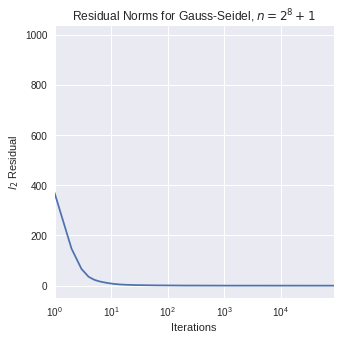

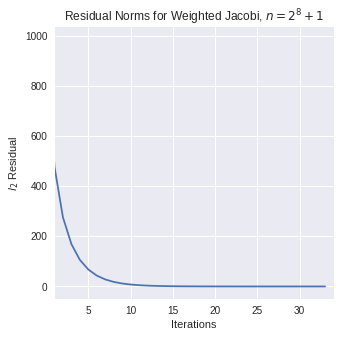

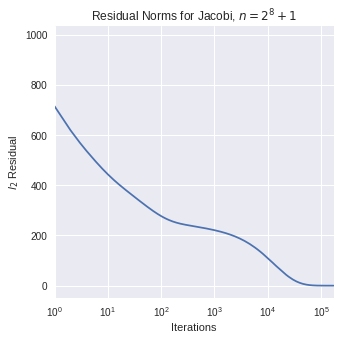

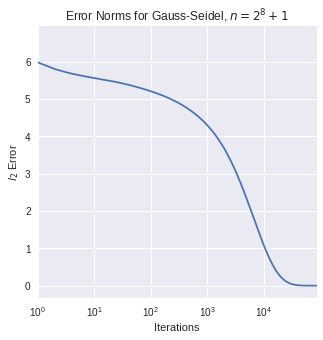

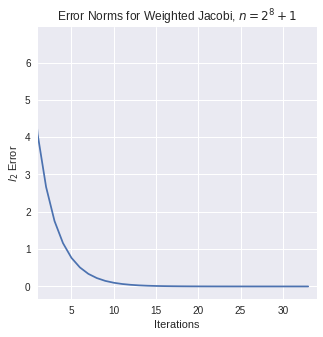

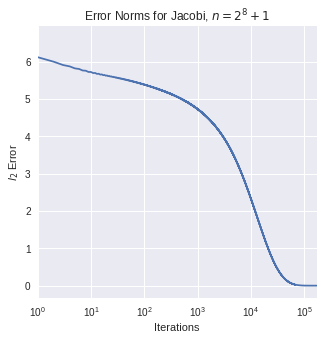

In [ ]:
# Look at the norms of the residual and error as a function of iterations for the high-resolution mesh
errors_GS_high_res = errors_GS_list[-1]
errors_WJ_high_res = errors_WJ_list[-1]
errors_J_high_res = errors_J_list[-1]
residuals_GS_high_res = residuals_GS_list[-1]
residuals_WJ_high_res = residuals_WJ_list[-1]
residuals_J_high_res = residuals_J_list[-1]

plt.figure()
plt.plot(residuals_GS_high_res)
plt.title('Residual Norms for Gauss-Seidel, $n=2^{8}+1$')
plt.ylabel('$l_2$ Residual')
plt.xlabel('Iterations')
plt.xscale('log')
plt.xlim(1, len(residuals_GS_high_res))
plt.grid('True')

plt.figure()
plt.plot(residuals_WJ_high_res)
plt.title('Residual Norms for Weighted Jacobi, $n=2^{8}+1$')
plt.ylabel('$l_2$ Residual')
plt.xlabel('Iterations')
plt.xlim(1, len(residuals_WJ_high_res))
plt.grid('True')

plt.figure()
plt.plot(residuals_J_high_res)
plt.title('Residual Norms for Jacobi, $n=2^{8}+1$')
plt.ylabel('$l_2$ Residual')
plt.xlabel('Iterations')
plt.xscale('log')
plt.xlim(1, len(residuals_J_high_res))
plt.grid('True')

plt.figure()
plt.plot(errors_GS_high_res)
plt.title('Error Norms for Gauss-Seidel, $n=2^{8}+1$')
plt.ylabel('$l_2$ Error')
plt.xlabel('Iterations')
plt.xscale('log')
plt.xlim(1, len(errors_GS_high_res))
plt.grid('True')

plt.figure()
plt.plot(errors_WJ_high_res)
plt.title('Error Norms for Weighted Jacobi, $n=2^{8}+1$')
plt.ylabel('$l_2$ Error')
plt.xlabel('Iterations')
plt.xlim(1, len(errors_WJ_high_res))
plt.grid('True')

plt.figure()
plt.plot(errors_J_high_res)
plt.title('Error Norms for Jacobi, $n=2^{8}+1$')
plt.ylabel('$l_2$ Error')
plt.xlabel('Iterations')
plt.xscale('log')
plt.xlim(1, len(errors_J_high_res))
plt.grid('True')

We can see that both Weighted-Jacobi and Gauss-Seidel converge to the true solution ($x=0$ since $A$ is invertible) as both the residual and the error norms go to zero. We can see that Weighted Jacobi converges faster than Gauss-Seidel by a few orders of magnitude. That is, it takes more iterations for Gauss-Seidel to produce an approximation $||x_k||_{l_2}<\epsilon$ than for Weighted Jacobi.

We know that from the Stein-Rosenburg Theorem, that Gauss-Seidel and Jacobi converge and diverge together. Furthermore, in the case of convergence we have $0<\rho (I-(D-L)^{-1}A) < \rho(I-D^{-1}A) < 1$ implying that Gauss-Seidel converges faster than Jacobi, as seen above. But the weights in Weighted Jacobi were chosen to modify the spectrum in a way that forces oscillatory modes of the error to decay fast enough that in this case it beats Gauss-Seidel.

Also plot the successive approximations to the true solution $x=0$ to visualize the smoothing effects of Gauss-Seidel and Weighted Jacobi

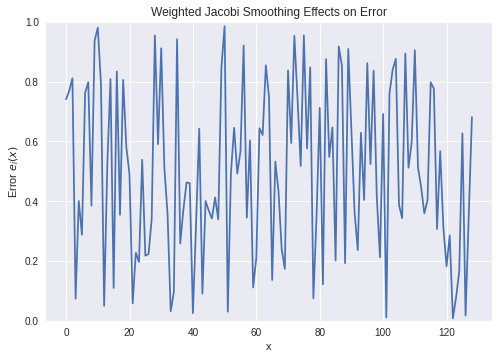

In [ ]:
# look at the error vector as a function of iterations for the high-resolution mesh
iterates_WJ = iterates_WJ_list[-1]
fig = plt.figure()
def build_plot_WJ(i):
    plt.cla()
    if i < len(iterates_WJ):
        plt.plot(iterates_WJ[i])
        plt.grid(True)
        plt.ylabel('Error $e_i(x)$')
        plt.xlabel('x')
        plt.ylim((0, 1))
        plt.title('Weighted Jacobi Smoothing Effects on Error')

ani.FuncAnimation(fig, build_plot_WJ)

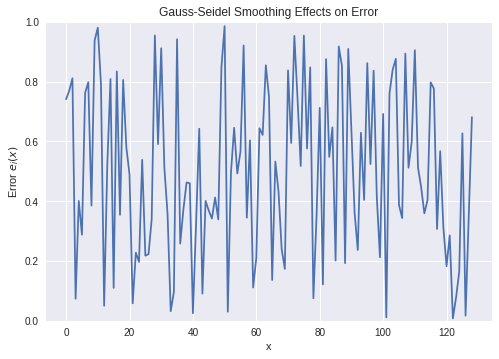

In [ ]:
# look at the error vector as a function of iterations for the high-resolution mesh
iterates_GS = iterates_GS_list[-1]
iterates_GS_sample = np.concatenate((iterates_GS[0:10], iterates_GS[10::50])) 

fig = plt.figure()
def build_plot_GS(i):
    plt.cla()
    if i < len(iterates_GS_sample):
        plt.plot(iterates_GS_sample[i])
        plt.grid(True)
        plt.ylabel('Error $e_i(x)$')
        plt.xlabel('x')
        plt.ylim((0, 1))
        plt.title('Gauss-Seidel Smoothing Effects on Error')

ani.FuncAnimation(fig, build_plot_GS)

We can see that as predicted the oscillatory modes of the error are quickly dampened by Weighted Jacobi and Gauss-Seidel, leaving a smoothed error that decays more slowly to zero. The error can be decomposed as a sum of oscillatory and smooth modes i.e. a Fourier series. For example, with Weighted Jacobi the oscillatory modes correspond to smaller eigenvalues of our matrix $I-\omega D^{-1}A$ since $\lambda=1-2\omega sin(\frac{k \pi}{2n})$. Since the decay rate is given by powers of the $\lambda$, smaller $\lambda$ and thus the oscillatory modes decay fastest.

Now plot the relative reduction in the residual norm per iteration

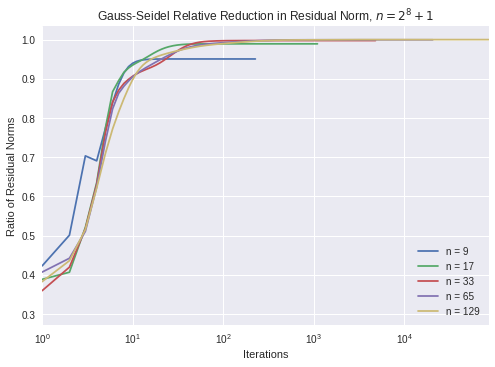

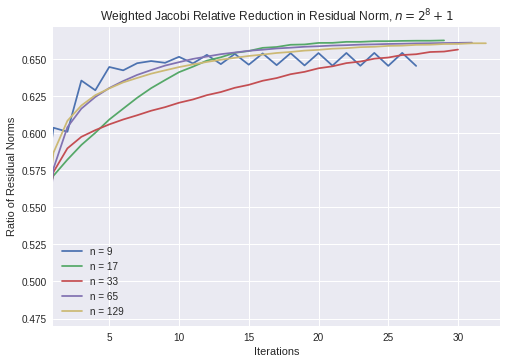

In [ ]:
plt.figure()
for i in range(len(n_list)):
  residuals_GS = residuals_GS_list[i]
  residuals_GS_rel = [residuals_GS[j]/residuals_GS[j-1] for j in range(1, len(residuals_GS))]
  plt.plot(residuals_GS_rel)
  plt.ylabel('Ratio of Residual Norms')
  plt.xlabel('Iterations')
  plt.xscale('log')
  plt.xlim(1, len(residuals_GS_rel))
  plt.title('Gauss-Seidel Relative Reduction in Residual Norm, $n=2^{8}+1$')
  plt.grid(True)

plt.legend(['n = ' + str(n_list[i]) for i in range(len(n_list))]);

plt.figure()
for i in range(len(n_list)):
  residuals_WJ = residuals_WJ_list[i]
  residuals_WJ_rel = [residuals_WJ[j]/residuals_WJ[j-1] for j in range(1, len(residuals_WJ))]
  plt.plot(residuals_WJ_rel)
  plt.ylabel('Ratio of Residual Norms')
  plt.xlabel('Iterations')
  plt.xlim(1, len(residuals_WJ_rel))
  plt.title('Weighted Jacobi Relative Reduction in Residual Norm, $n=2^{8}+1$')
  plt.grid(True)

plt.legend(['n = ' + str(n_list[i]) for i in range(len(n_list))]);

As the number of iterations increases, the relative reduction in residual norm $\frac{||Ax^(l)||}{||Ax^{(l-1)}||}$ approaches one for Gauss-Seidel. However, we can see that the rate of convergence to one slows down drastically. This slow-down corresponds to only the smooth modes remaining in the error. We can see the same effect for Weighted Jacobi.

For Gauss-Seidel and Weighted Jacobi, as predicted there does not seem to be much of an effect of the mesh spacing on the relative reduction in residual norm. For example, with Gauss-Seidel the slope of the curves before the slow-down (the elbows in curves) corresponding to different mesh spacings are all approximately the same. Furthermore, the number of iterations required to get the oscillatory modes of the error small is approximately the same regardless of mesh spacing: after only ten iterations, all of the curves have show remarkable increases in the relative residual norms. After ten iterations, only the smooth modes of the error are left and the relative residual norms do not change much from iteration to iteration acrosss all mesh spacings.

## Convergence of Weighted Jacobi and Gauss-Seidel for $x_i^{0}(x) = sin(k\pi\frac{i}{n})$

Instead of a random initial guess to solve $Ax=0$, our initial guess is a $sin(k\pi x)$ function. First we fix the mesh spacing and explore how the convergence depends on the frequency parameter  $k$. We expect to see faster convergence for the oscillatory modes that correspond to higher values of $k$.

In [ ]:
# fix the mesh spacing and create a range of frequency parameters to explore
n = 2**7+1
k_list = [2**k for k in range(0, 6)]

# tolerance for convergence
eps = 10**(-5)

residuals_GS_list, residuals_WJ_list = [], []
errors_GS_list, errors_WJ_list = [], []
iterates_GS_list, iterates_WJ_list = [], []

A = stiffness(n, True)
b = np.zeros((n,))
x_true = np.linalg.solve(A, b)

for k in k_list:
  x0 = np.sin(k*np.pi*np.linspace(0, 1, n))
  iterates_GS, residuals_GS, errors_GS = GS(A, b, eps, x_true, x0); iterates_WJ, residuals_WJ, errors_WJ = WJ(A, b, eps, x_true, x0, 2/3)
  residuals_GS_list.append(residuals_GS); residuals_WJ_list.append(residuals_WJ)
  errors_GS_list.append(errors_GS); errors_WJ_list.append(errors_WJ)
  iterates_GS_list.append(iterates_GS); iterates_WJ_list.append(iterates_WJ)

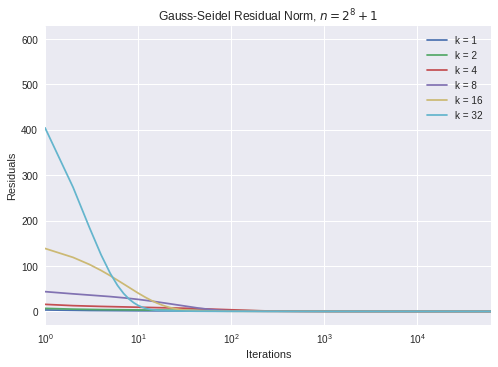

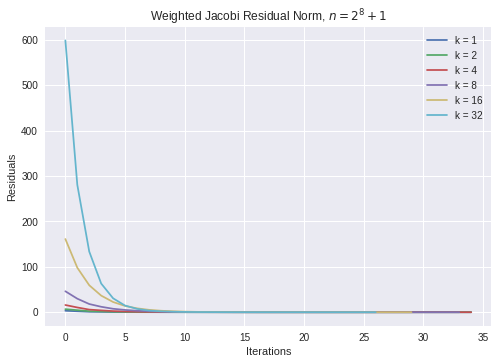

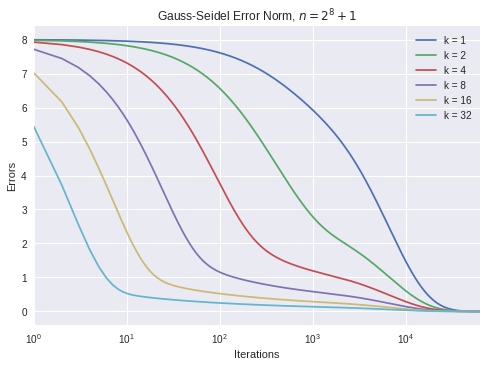

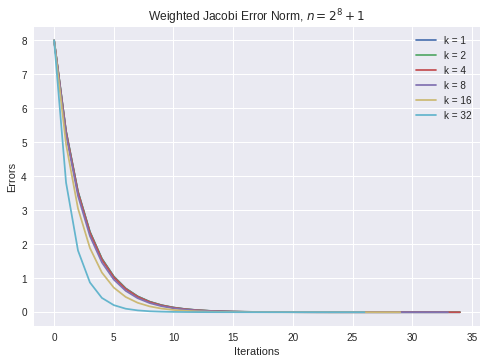

In [ ]:
plt.figure()
for k in range(len(k_list)):
  residuals_GS = residuals_GS_list[k]
  plt.plot(residuals_GS)
  plt.ylabel('Residuals')
  plt.xlabel('Iterations')
  plt.xscale('log')
  plt.xlim(1, len(residuals_GS))
  plt.title('Gauss-Seidel Residual Norm, $n=2^{8}+1$')
  plt.grid(True)

plt.legend(['k = ' + str(k_list[k]) for k in range(len(k_list))]);

plt.figure()
for k in range(len(k_list)):
  residuals_WJ = residuals_WJ_list[k]
  plt.plot(residuals_WJ)
  plt.ylabel('Residuals')
  plt.xlabel('Iterations')
  plt.title('Weighted Jacobi Residual Norm, $n=2^{8}+1$')
  plt.grid(True)

plt.legend(['k = ' + str(k_list[k]) for k in range(len(k_list))]);

plt.figure()
for k in range(len(k_list)):
  errors_GS = errors_GS_list[k]
  plt.plot(errors_GS)
  plt.ylabel('Errors')
  plt.xlabel('Iterations')
  plt.xscale('log')
  plt.xlim(1, len(errors_GS))
  plt.title('Gauss-Seidel Error Norm, $n=2^{8}+1$')
  plt.grid(True)

plt.legend(['k = ' + str(k_list[k]) for k in range(len(k_list))]);

plt.figure()
for k in range(len(k_list)):
  errors_WJ = errors_WJ_list[k]
  plt.plot(errors_WJ)
  plt.ylabel('Errors')
  plt.xlabel('Iterations')
  plt.title('Weighted Jacobi Error Norm, $n=2^{8}+1$')
  plt.grid(True)

plt.legend(['k = ' + str(k_list[k]) for k in range(len(k_list))]);

As predicted, we see that higher oscillatory modes converge much faster than the lower smooth modes. As explained above for the Weighted Jacobi case, this is due to the relationship between $\lambda$ and $k$: $\lambda=1-2\omega sin(\frac{k \pi}{2(n+1)})$. Since the decay rate is given by powers of the $\lambda$, smaller $\lambda$ and thus the oscillatory modes decay fastest.

We will now explore if this relationship changes as the mesh spacing changes

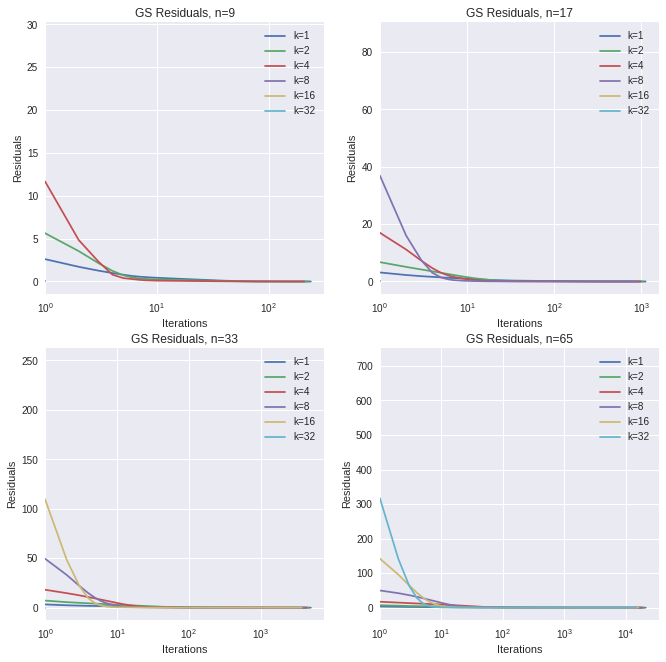

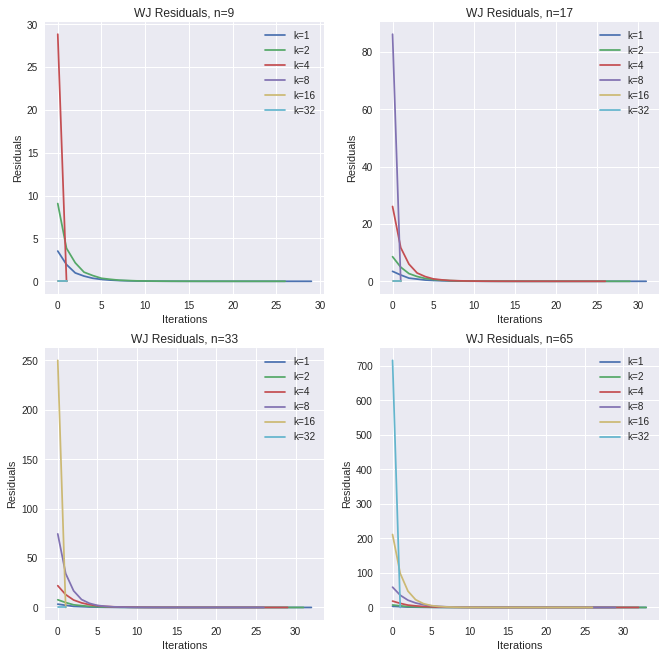

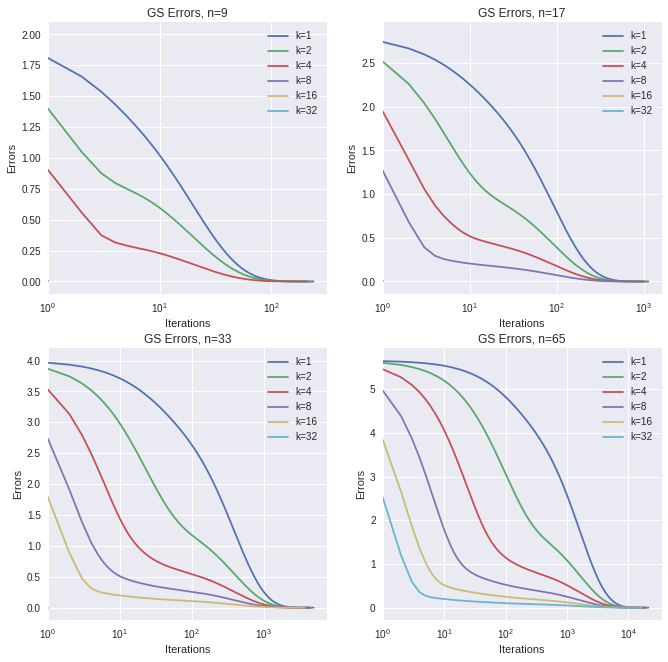

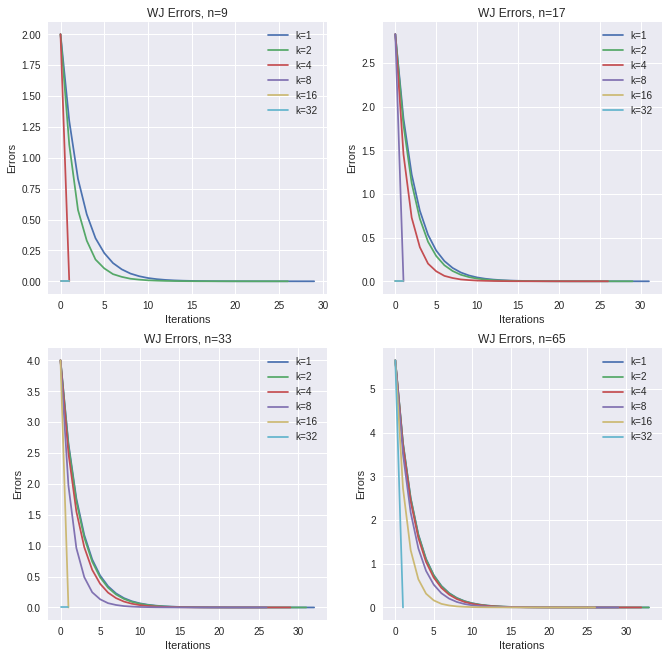

In [ ]:
n_list = [2**n+1 for n in range(3, 7)]
k_list = [2**k for k in range(0, 6)]

# tolerance for convergence
eps = 10**(-5)

fig1, axs1 = plt.subplots(2, 2, figsize=(11,11));
fig2, axs2 = plt.subplots(2, 2, figsize=(11,11));
fig3, axs3 = plt.subplots(2, 2, figsize=(11,11));
fig4, axs4 = plt.subplots(2, 2, figsize=(11,11));
count = 0

for n in n_list:
  A = stiffness(n, True)
  b = np.zeros((n,))
  x_true = np.linalg.solve(A, b)

  residuals_GS_list, residuals_WJ_list = [], []
  errors_GS_list, errors_WJ_list = [], []
  iterates_GS_list, iterates_WJ_list = [], []

  for k in k_list:
    x0 = np.sin(k*np.pi*np.linspace(0, 1, n))
    iterates_GS, residuals_GS, errors_GS = GS(A, b, eps, x_true, x0)
    iterates_WJ, residuals_WJ, errors_WJ = WJ(A, b, eps, x_true, x0, 2/3)
    residuals_GS_list.append(residuals_GS); residuals_WJ_list.append(residuals_WJ)
    errors_GS_list.append(errors_GS); errors_WJ_list.append(errors_WJ)
    iterates_GS_list.append(iterates_GS); iterates_WJ_list.append(iterates_WJ)

  if count == 0:
    pos1 = 0
    pos2 = 0
  elif count == 1:
    pos1 = 0
    pos2 = 1
  elif count == 2:
    pos1 = 1
    pos2 = 0
  elif count == 3:
    pos1 = 1
    pos2 = 1
  
  # plot subplots for each mesh spacings
  for k in range(len(k_list)):
    residuals_GS = residuals_GS_list[k]
    axs1[pos1, pos2].plot(residuals_GS)
    axs1[pos1, pos2].set_xscale('log');
    axs1[pos1, pos2].set_xlim(left=1);
    axs1[pos1, pos2].set_title('GS Residuals, n=' + str(n));
    axs1[pos1, pos2].set_ylabel('Residuals');
    axs1[pos1, pos2].set_xlabel('Iterations');
    axs1[pos1, pos2].grid(True);

  axs1[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  for k in range(len(k_list)):
    residuals_WJ = residuals_WJ_list[k]
    axs2[pos1, pos2].plot(residuals_WJ)
    axs2[pos1, pos2].set_title('WJ Residuals, n=' + str(n));
    axs2[pos1, pos2].set_ylabel('Residuals');
    axs2[pos1, pos2].set_xlabel('Iterations');
    axs2[pos1, pos2].grid(True);

  axs2[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  for k in range(len(k_list)):
    errors_GS = errors_GS_list[k]
    axs3[pos1, pos2].plot(errors_GS)
    axs3[pos1, pos2].set_xscale('log');
    axs3[pos1, pos2].set_xlim(left=1);
    axs3[pos1, pos2].set_title('GS Errors, n=' + str(n));
    axs3[pos1, pos2].set_ylabel('Errors');
    axs3[pos1, pos2].set_xlabel('Iterations');
    axs3[pos1, pos2].grid(True);

  axs3[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  for k in range(len(k_list)):
    errors_WJ = errors_WJ_list[k]
    axs4[pos1, pos2].plot(errors_WJ)
    axs4[pos1, pos2].set_title('WJ Errors, n=' + str(n));
    axs4[pos1, pos2].set_ylabel('Errors');
    axs4[pos1, pos2].set_xlabel('Iterations');
    axs4[pos1, pos2].grid(True);

  axs4[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  count += 1

We can see from the above plots that there is an effect of the grid spacing on the number of iterations it takes to converge. For example, with Gauss-Seidel and $n=9$ we see that the lower modes take on the order of $10^2$ iterations to converge and the higher modes converge quickly and do not appear on the log-scaled plot. However, with Gauss-Seidel and $n=65$ we see that both low and high modes take on the order of $10^4$ iterations to converge. The same story is true for Weighted-Jacobi, however the convergence is fast enough in all cases this pattern is less easy to see. We can see that for $n=9$ the $k=16$ mode converges after only one iteration but for $n=65$ it takes approximate $25$ iterations to converge. But regardless of $n$, the pattern remains from before and higher modes still converge must faster than the lower modes.

Now we will look at the dependence of the above analysis on $\omega$ for Weighted Jacobi

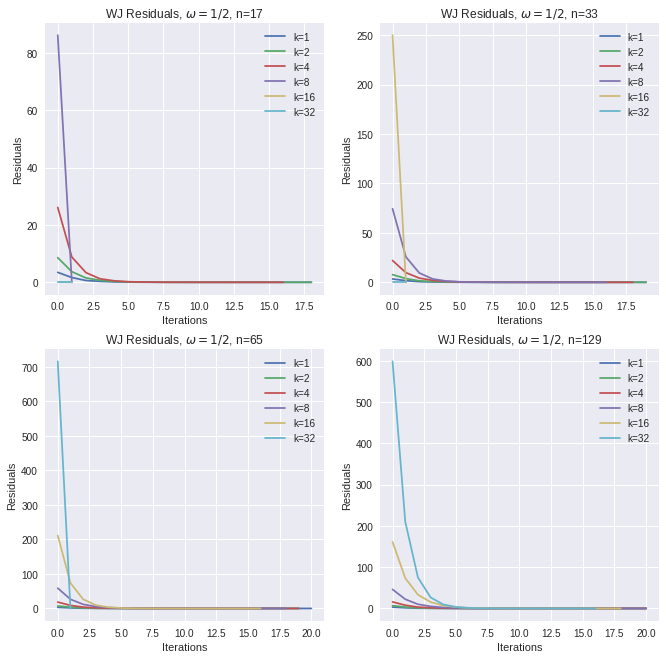

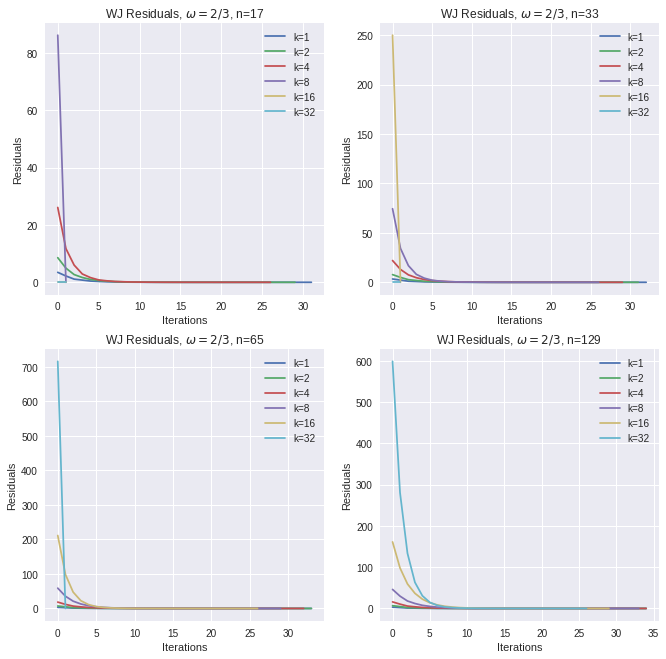

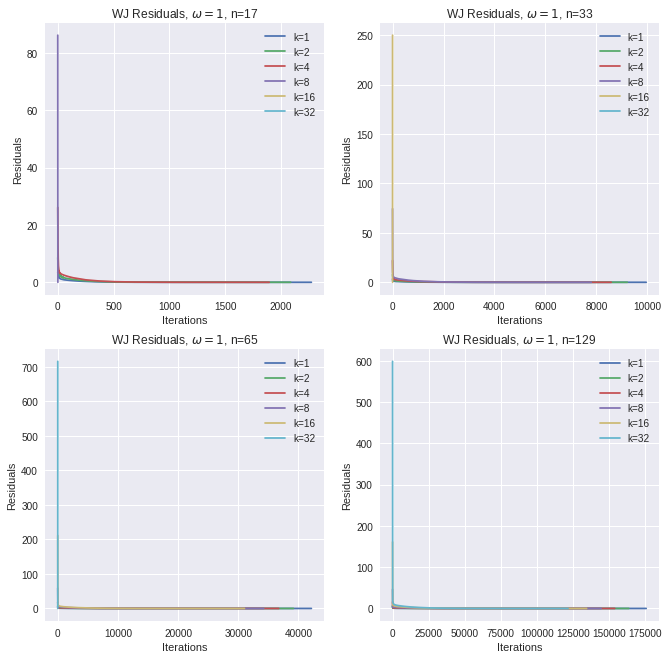

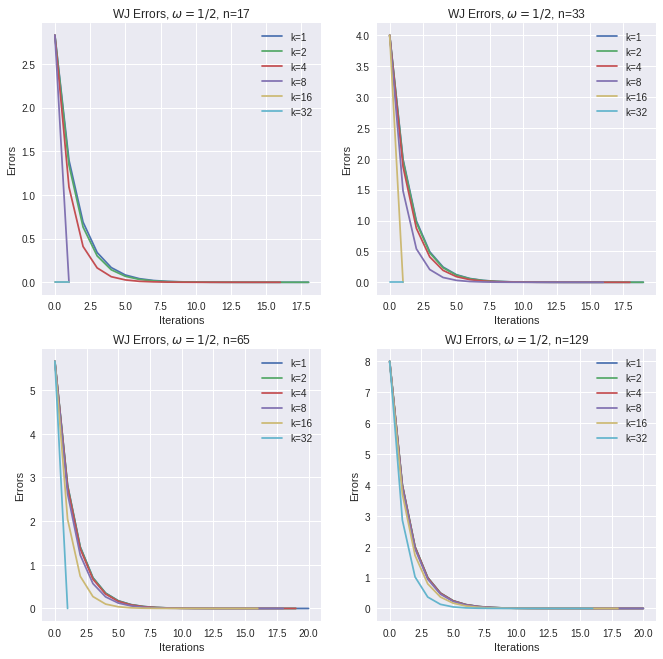

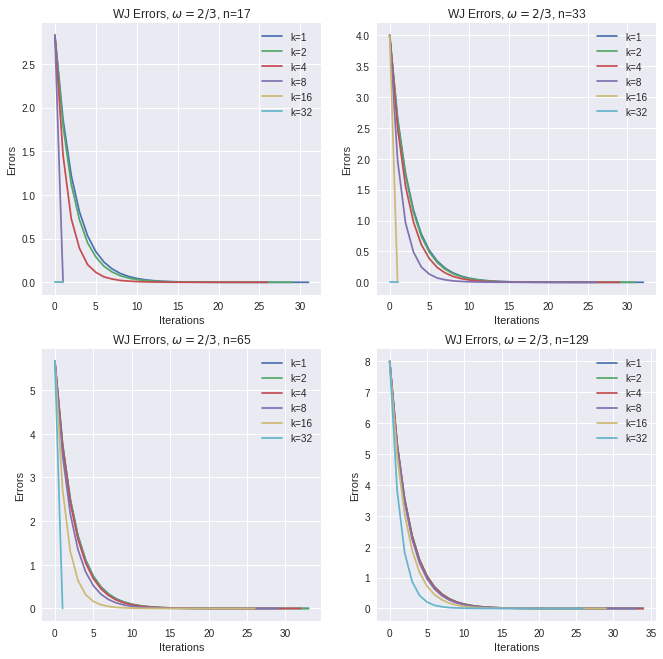

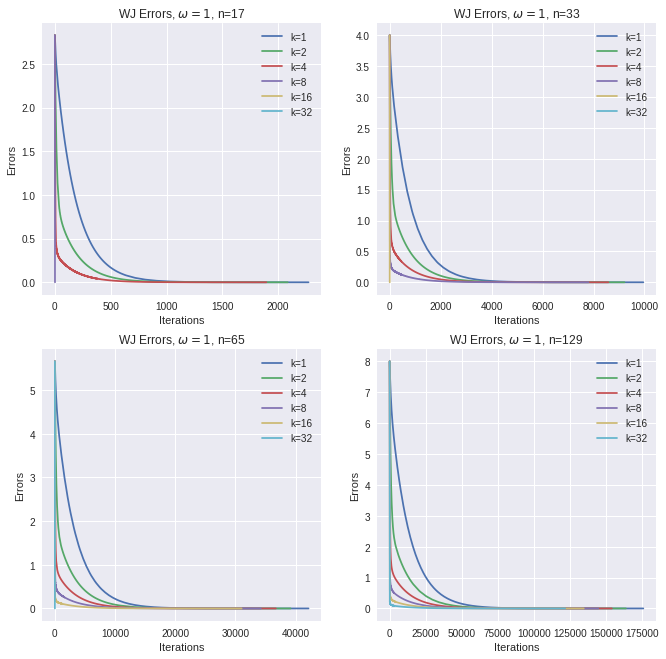

In [ ]:
n_list = [2**n+1 for n in range(4, 8)]
k_list = [2**k for k in range(0, 6)]

# tolerance for convergence
eps = 10**(-5)

fig1, axs1 = plt.subplots(2, 2, figsize=(11,11));
fig2, axs2 = plt.subplots(2, 2, figsize=(11,11));
fig3, axs3 = plt.subplots(2, 2, figsize=(11,11));
fig4, axs4 = plt.subplots(2, 2, figsize=(11,11));
fig5, axs5 = plt.subplots(2, 2, figsize=(11,11));
fig6, axs6 = plt.subplots(2, 2, figsize=(11,11));
count = 0

for n in n_list:
  A = stiffness(n, True)
  b = np.zeros((n,))
  x_true = np.linalg.solve(A, b)

  residuals_WJ_list1, errors_WJ_list1, iterates_WJ_list1 = [], [], []
  residuals_WJ_list2, errors_WJ_list2, iterates_WJ_list2 = [], [], []
  residuals_WJ_list3, errors_WJ_list3, iterates_WJ_list3 = [], [], []


  for k in k_list:
    x0 = np.sin(k*np.pi*np.linspace(0, 1, n))
    iterates_WJ, residuals_WJ, errors_WJ = WJ(A, b, eps, x_true, x0, 1/2)
    residuals_WJ_list1.append(residuals_WJ)
    errors_WJ_list1.append(errors_WJ)
    iterates_WJ_list1.append(iterates_WJ)

    iterates_WJ, residuals_WJ, errors_WJ = WJ(A, b, eps, x_true, x0, 2/3)
    residuals_WJ_list2.append(residuals_WJ)
    errors_WJ_list2.append(errors_WJ)
    iterates_WJ_list2.append(iterates_WJ)

    iterates_WJ, residuals_WJ, errors_WJ = WJ(A, b, eps, x_true, x0, 1)
    residuals_WJ_list3.append(residuals_WJ)
    errors_WJ_list3.append(errors_WJ)
    iterates_WJ_list3.append(iterates_WJ)

  if count == 0:
    pos1 = 0
    pos2 = 0
  elif count == 1:
    pos1 = 0
    pos2 = 1
  elif count == 2:
    pos1 = 1
    pos2 = 0
  elif count == 3:
    pos1 = 1
    pos2 = 1
  
  # plot subplots for each mesh spacings
  for k in range(len(k_list)):
    residuals_WJ = residuals_WJ_list1[k]
    axs1[pos1, pos2].plot(residuals_WJ)
    axs1[pos1, pos2].set_title('WJ Residuals, $\omega=1/2$, n=' + str(n));
    axs1[pos1, pos2].set_ylabel('Residuals');
    axs1[pos1, pos2].set_xlabel('Iterations');
    axs1[pos1, pos2].grid(True);

  axs1[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  for k in range(len(k_list)):
    residuals_WJ = residuals_WJ_list2[k]
    axs2[pos1, pos2].plot(residuals_WJ)
    axs2[pos1, pos2].set_title('WJ Residuals, $\omega=2/3$, n=' + str(n));
    axs2[pos1, pos2].set_ylabel('Residuals');
    axs2[pos1, pos2].set_xlabel('Iterations');
    axs2[pos1, pos2].grid(True);

  axs2[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  for k in range(len(k_list)):
    residuals_WJ = residuals_WJ_list3[k]
    axs3[pos1, pos2].plot(residuals_WJ)
    axs3[pos1, pos2].set_xscale('log');
    axs3[pos1, pos2].set_title('WJ Residuals, $\omega=1$, n=' + str(n));
    axs3[pos1, pos2].set_ylabel('Residuals');
    axs3[pos1, pos2].set_xlabel('Iterations');
    axs3[pos1, pos2].grid(True);

  axs3[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  for k in range(len(k_list)):
    errors_WJ = errors_WJ_list1[k]
    axs4[pos1, pos2].plot(errors_WJ)
    axs4[pos1, pos2].set_title('WJ Errors, $\omega=1/2$, n=' + str(n));
    axs4[pos1, pos2].set_ylabel('Errors');
    axs4[pos1, pos2].set_xlabel('Iterations');
    axs4[pos1, pos2].grid(True);

  axs4[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  for k in range(len(k_list)):
    errors_WJ = errors_WJ_list2[k]
    axs5[pos1, pos2].plot(errors_WJ)
    axs5[pos1, pos2].set_title('WJ Errors, $\omega=2/3$, n=' + str(n));
    axs5[pos1, pos2].set_ylabel('Errors');
    axs5[pos1, pos2].set_xlabel('Iterations');
    axs5[pos1, pos2].grid(True);

  axs5[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  for k in range(len(k_list)):
    errors_WJ = errors_WJ_list3[k]
    axs6[pos1, pos2].plot(errors_WJ)
    axs6[pos1, pos2].set_xscale('log');
    axs6[pos1, pos2].set_title('WJ Errors, $\omega=1$, n=' + str(n));
    axs6[pos1, pos2].set_ylabel('Errors');
    axs6[pos1, pos2].set_xlabel('Iterations');
    axs6[pos1, pos2].grid(True);

  axs6[pos1, pos2].legend(['k=' + str(k_list[k]) for k in range(len(k_list))]);

  count += 1

Regardless of the value of $\omega$, higher numbers of grid points $n$ results in longer convergence times i.e. more iterations are necessary for the approximations to be within $\epsilon$ of the true solution. This is true for all modes. This makes sense, as each step of Weighted-Jacobi for example is $O(n)$ and we cannot expect any kind of constant time convergence. For example, in the above plot for $\omega=1$ there is a clear dependence on $n$ in the subplots regardless of the value of the modes $k$ as before when $\omega=\frac{2}{3}$. The higher modes seem to be less affected since they still converge after only 1 or 2 iterations. Clearly $\omega=\frac{2}{3}$ is better than $\omega=1$ as it takes orders of magnitude less iterations to converge. Oddly enough, $\omega=\frac{1}{2}$ converges faster across the board for all values of $n$ and $k$. This could be because $\omega$ was optimized across a range or mix of high modes and not for any one specific mode.